In [32]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    RobustScaler,
    MinMaxScaler,
    StandardScaler
)

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from kneed import KneeLocator



Leer CSV y sacar el dataframe

In [14]:
pd.set_option("display.max_rows", None)  # Muestra todas las filas
pd.set_option("display.max_columns", None)  # Muestra todas las columnas
pd.set_option("display.max_colwidth", None)  # No truncar texto en celdas


# Cargar el CSV en un DataFrame
df = pd.read_csv("semillas.csv")

Sacar X e y

In [15]:
variable_objetivo = "clase"

X = df.drop(columns=[variable_objetivo])  
y = df[variable_objetivo]  

Para cada método de escalado sacar el scatter plot

MinMax
Varianza explicada por el componente 1: 0.7890
Varianza explicada por el componente 2: 0.1291
Varianza explicada total: 0.9181


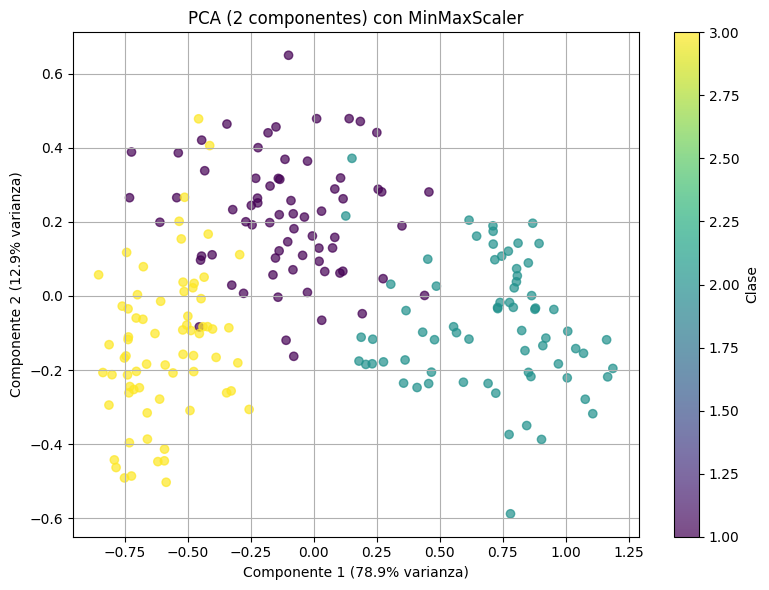

Standard
Varianza explicada por el componente 1: 0.7187
Varianza explicada por el componente 2: 0.1711
Varianza explicada total: 0.8898


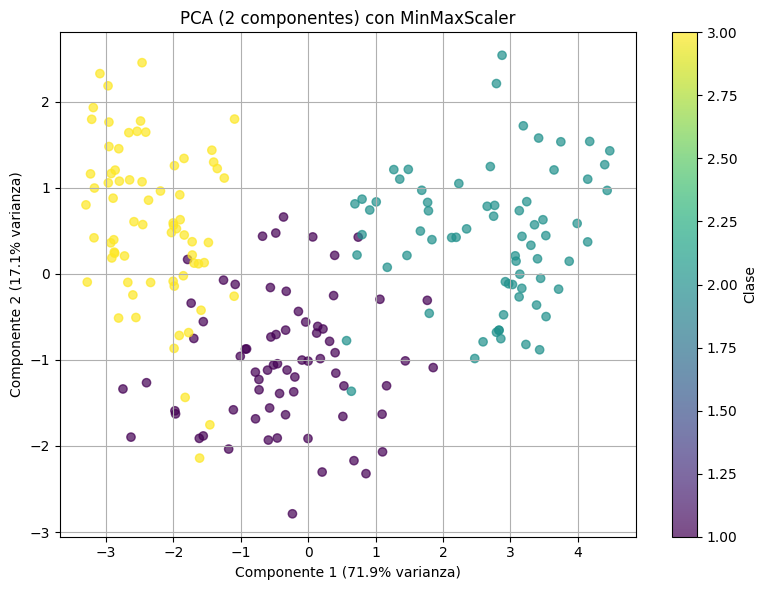

Robust
Varianza explicada por el componente 1: 0.6695
Varianza explicada por el componente 2: 0.1996
Varianza explicada total: 0.8691


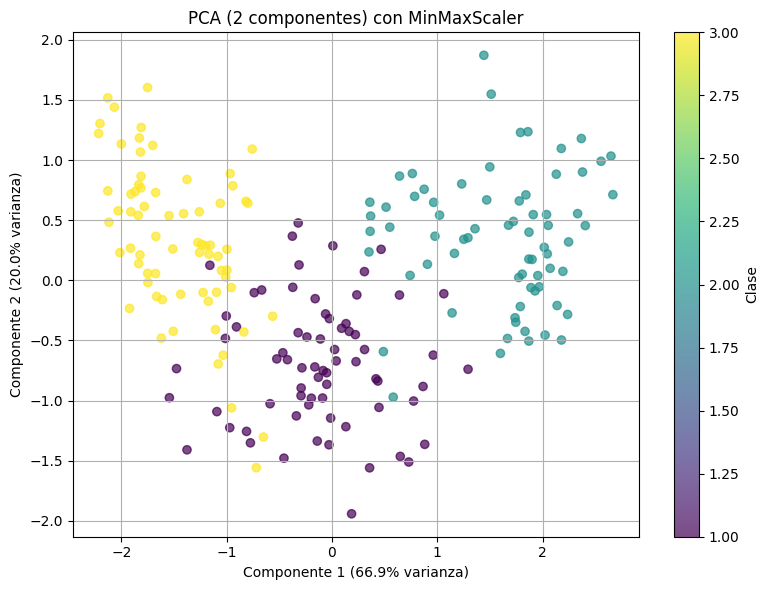

In [16]:
scaling_methods = {
    "MinMax": MinMaxScaler(),
    "Standard": StandardScaler(),
    "Robust": RobustScaler()
}

for scale_name, scaler in scaling_methods.items():

# Crear pipeline con MinMaxScaler y PCA a 2 componentes
    clf_pca = Pipeline(steps=[
        ('scaler', scaler),
        ('pca', PCA(n_components=2))
    ])

    # Aplicar transformación
    X_pca = clf_pca.fit_transform(X)

    pca = PCA(n_components=2)

    varianza = clf_pca.named_steps['pca'].explained_variance_ratio_
    print(scale_name)
    print(f"Varianza explicada por el componente 1: {varianza[0]:.4f}")
    print(f"Varianza explicada por el componente 2: {varianza[1]:.4f}")
    print(f"Varianza explicada total: {varianza.sum():.4f}")

    # Visualizar
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.title('PCA (2 componentes) con MinMaxScaler')
    plt.xlabel(f'Componente 1 ({varianza[0]*100:.1f}% varianza)')
    plt.ylabel(f'Componente 2 ({varianza[1]*100:.1f}% varianza)')
    plt.colorbar(scatter, label='Clase')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Aquí se puede observar que MinMax es el que mejor separa los datos, con menos datos mezclados y separando los grupos de manera más clara, dentro de que los tres los separan de manera parecida. Además, la varianza explicada por los componentes es mayor que el resto

K-means

Método del codo y siluetas

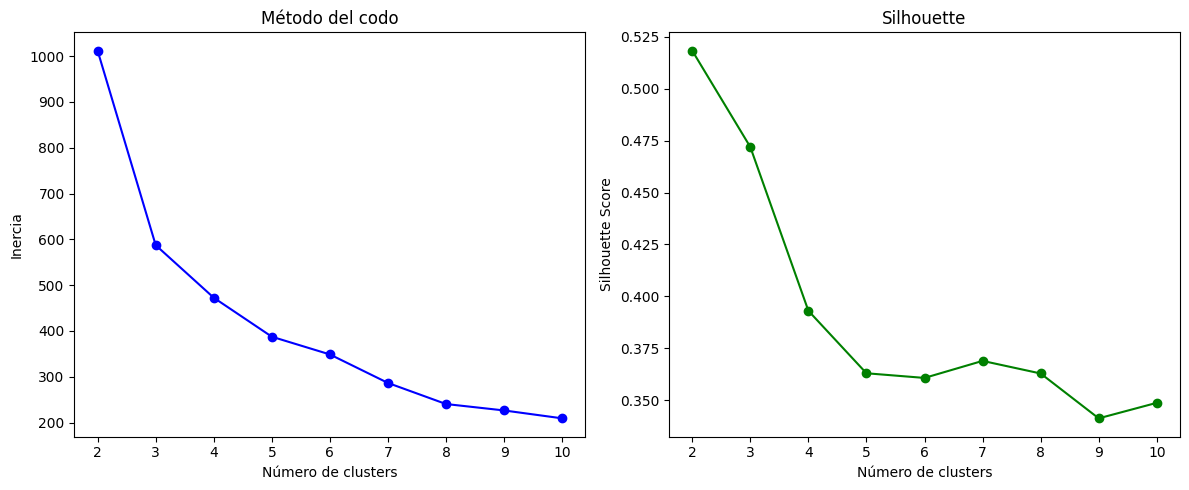

In [23]:
inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=432094)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

# Gráfico método del codo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método del codo")


# Gráfico silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, 'go-')
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette")

plt.tight_layout()
plt.show()

Interpretación método del codo: Se busca el punto donde la inercia (error) deja de bajar rápido. En este caso ese punto es n=3

Interpretación siluetas: Se busca el valor más alto. En este caso n=2



Hierarchical Clustering/Dendrogramas

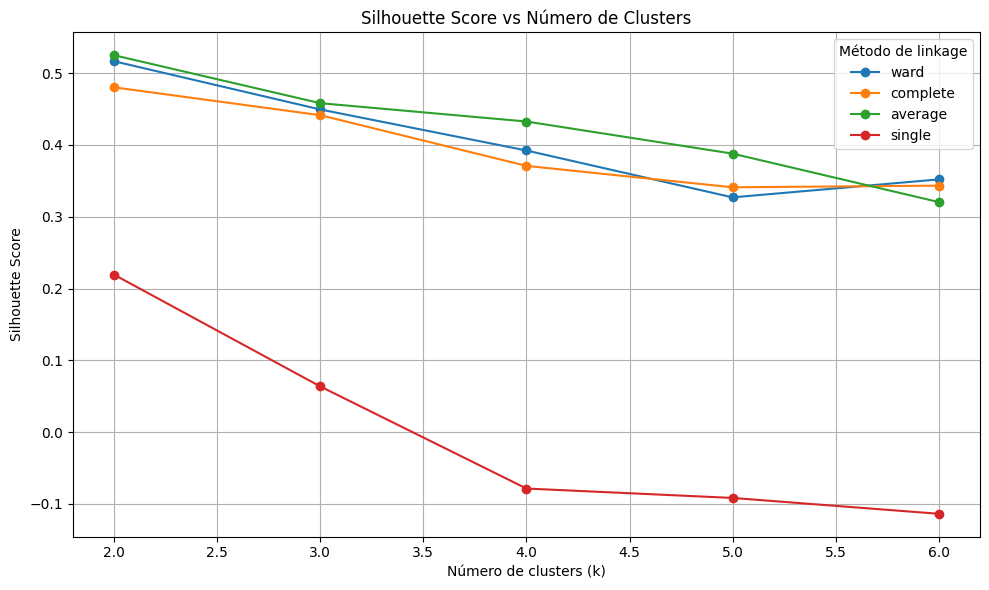

In [30]:
linkage_methods = ['ward', 'complete', 'average', 'single']

k_values = range(2, 7)


silhouette_scores = {method: [] for method in linkage_methods}

for method in linkage_methods:
    for k in k_values:
        clustering = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = clustering.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores[method].append(score)

# Graficar
plt.figure(figsize=(10, 6))
for method in linkage_methods:
    plt.plot(k_values, silhouette_scores[method], marker='o', label=method)

plt.title("Silhouette Score vs Número de Clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend(title="Método de linkage")
plt.grid(True)
plt.tight_layout()
plt.show()

El mejor K es 2, dado que ofrece los valores más altos

Dendrogramas

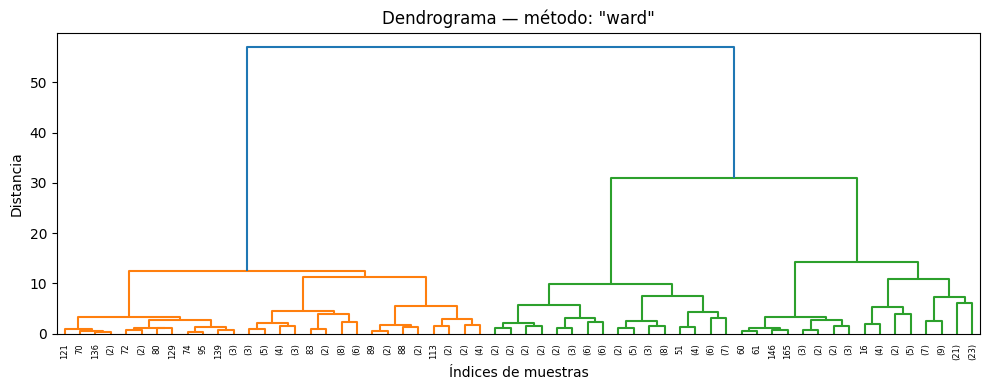

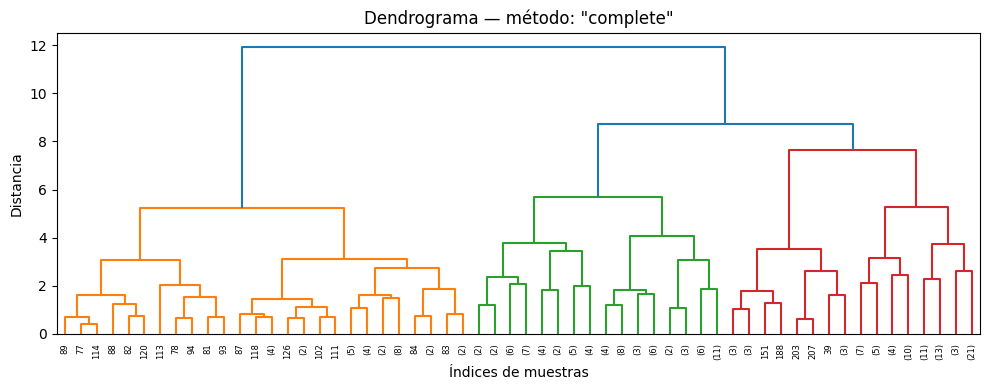

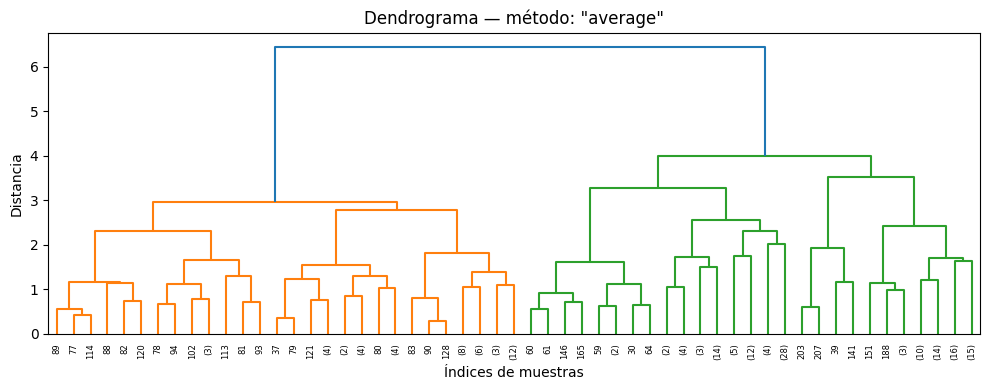

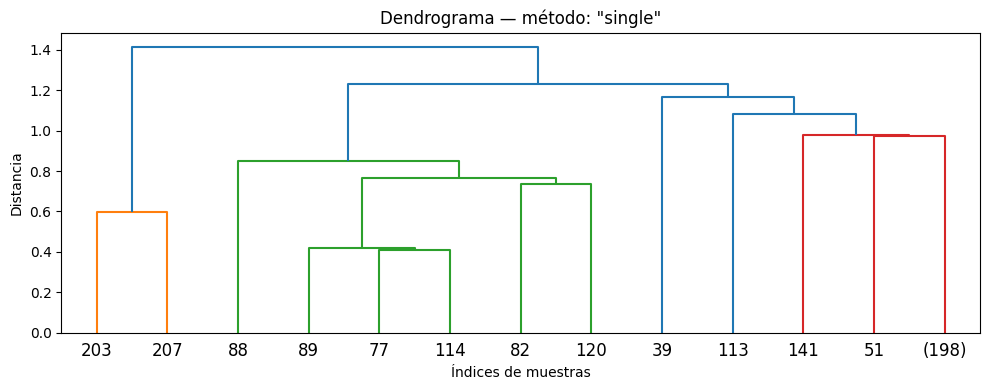

In [ ]:

for method in linkage_methods:
    Z = linkage(X, method=method)
    
    plt.figure(figsize=(10, 4))
    
    dendrogram(Z, truncate_mode='level', p=5)

    plt.title(f'Dendrograma — método: "{method}"')
    plt.xlabel("Índices de muestras")
    plt.ylabel("Distancia")
    plt.tight_layout()
    plt.show()


DBScan

In [35]:


# Rango de min_samples (minpts)
min_samples_list = [3, 4, 5, 6, 7]
best_result = {'score': -1}

for min_samples in min_samples_list:
    # Calcular k-distancia
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(X)
    distances, _ = nbrs.kneighbors(X)
    k_distances = np.sort(distances[:, -1])

    # Detectar el "codo" automáticamente para estimar eps
    knee = KneeLocator(range(len(k_distances)), k_distances, curve='convex', direction='increasing')
    if knee.knee is None:
        continue
    eps = k_distances[knee.knee]

    # Aplicar DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        score = silhouette_score(X, labels)
        if score > best_result['score']:
            best_result.update({
                'score': score,
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'labels': labels,
            })

# Mostrar el mejor resultado
if best_result['score'] > -1:
    print(f"Mejor configuración:")
    print(f"• min_samples: {best_result['min_samples']}")
    print(f"• eps: {best_result['eps']:.3f}")
    print(f"• Clusters encontrados: {best_result['n_clusters']}")
    print(f"• Silhouette Score: {best_result['score']:.3f}")
else:
    print("No se encontró una configuración válida de DBSCAN.")



Mejor configuración:
• min_samples: 3
• eps: 1.030
• Clusters encontrados: 2
• Silhouette Score: 0.120


A excepción de las siluetas en K-means, todos los demás métodos muestran que el número de clusters óptimo es de 2